<a href="https://colab.research.google.com/github/JamesChoi722/JamesChoi722/blob/main/Final_Capstone_BTC_Price_Prediction_by_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install plotly==5.4.0

Importing Library

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

Loading Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BTC-USD.csv to BTC-USD (2).csv


In [ ]:
maindf = pd.read_csv('BTC-USD.csv')

In [ ]:
print('Total number of days present in the dataset: ', maindf.shape[0])
print('Total number of fields present in the dataset:', maindf.shape[1])

Total number of days present in the dataset:  2622
Total number of fields present in the dataset: 7


In [ ]:
maindf.shape

(2622, 7)

In [ ]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2617,2021-11-16,63721.195313,63721.195313,59016.335938,60161.246094,60161.246094,4.684434e+10
2618,2021-11-17,60139.621094,60823.609375,58515.410156,60368.011719,60368.011719,3.917839e+10
2619,2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719,56942.136719,4.138834e+10
2620,2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125,58119.578125,3.870241e+10
2621,2021-11-20,58137.187500,59040.605469,57976.265625,58592.691406,58592.691406,3.546546e+10


In [ ]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2622 entries, 0 to 2621
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2622 non-null   object 
 1   Open       2618 non-null   float64
 2   High       2618 non-null   float64
 3   Low        2618 non-null   float64
 4   Close      2618 non-null   float64
 5   Adj Close  2618 non-null   float64
 6   Volume     2618 non-null   float64
dtypes: float64(6), object(1)
memory usage: 143.5+ KB


In [ ]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2618.000000,2618.000000,2618.000000,2618.000000,2618.000000,2.618000e+03
mean,10107.185814,10388.667871,9804.463297,10128.636785,10128.636785,1.402899e+10
std,14974.074521,15400.237861,14501.069297,15002.140788,15002.140788,1.993673e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,582.505249,589.548996,575.807220,583.945480,583.945480,7.491067e+07
50%,5751.195068,5881.806885,5551.975098,5760.689697,5760.689697,4.682051e+09
75%,9883.589111,10152.540527,9661.860352,9889.221192,9889.221192,2.289970e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


Checking for Null Values

In [ ]:
print('Null Values:', maindf.isnull().values.sum())

Null Values: 24


In [ ]:
print('NA values:', maindf.isnull().values.any())

NA values: True


In [ ]:
maindf = maindf.dropna() 

In [ ]:
print('Null values:', maindf.isnull().values.sum())

Null values: 0


In [ ]:
print('NA balues:', maindf.isnull().values.any())

NA balues: False


In [ ]:
maindf.shape

(2618, 7)

EDA (Exploratory Data Analysis)

In [ ]:
sd = maindf.iloc[0][0]
ed = maindf.iloc[-1][0]

print('Starting Date', sd)
print('Ending DAte', ed)

Starting Date 2014-09-17
Ending DAte 2021-11-20


BTC Price Analysis of 2015

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2015 = maindf.loc[(maindf['Date'] >= '2015-01-01')
                     & (maindf['Date'] < '2016-01-01')]

y_2015.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
106,2015-01-01,320.434998,320.434998,314.002991,314.248993
107,2015-01-02,314.079010,315.838989,313.565002,315.032013
108,2015-01-03,314.846008,315.149994,281.082001,281.082001
109,2015-01-04,281.145996,287.230011,257.612000,264.195007
110,2015-01-05,265.084015,278.341003,265.084015,274.473999
...,...,...,...,...,...
466,2015-12-27,416.514008,424.006989,408.882996,422.822998
467,2015-12-28,423.342987,429.769012,418.480988,422.278992
468,2015-12-29,422.097992,432.983002,420.627014,432.983002
469,2015-12-30,433.299988,434.386993,422.084015,426.619995


Monthly Average BTC price of 2015

In [ ]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,251.799905,248.782547
February,232.821856,234.153645
March,269.278419,269.042259
April,235.708667,235.491534
May,237.161806,236.997001
June,236.941433,238.081766
July,278.857679,279.563740
August,252.986774,250.733805
September,233.486733,233.595533


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2015 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' 2015 Monthly High and Low BTC price')
fig.show()

In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2015 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

BTC Price Analysis of 2016

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2016 = maindf.loc[(maindf['Date'] >= '2016-01-01')
                     & (maindf['Date'] < '2017-01-01')]

y_2016.drop(y_2016[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
471,2016-01-01,430.721008,436.246002,427.515015,434.334015
472,2016-01-02,434.622009,436.062012,431.869995,433.437988
473,2016-01-03,433.578003,433.743011,424.705994,430.010986
474,2016-01-04,430.061005,434.516998,429.084015,433.091003
475,2016-01-05,433.069000,434.182007,429.675995,431.959991
...,...,...,...,...,...
832,2016-12-27,908.354004,940.047974,904.255005,933.197998
833,2016-12-28,934.830994,975.921021,934.830994,975.921021
834,2016-12-29,975.125000,979.396973,954.502991,973.497009
835,2016-12-30,972.534973,972.534973,934.833008,961.237976


Monthly Average BTC price of 2016

In [ ]:
monthvise= y_2016.groupby(y_2016['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,412.805902,410.844485
February,402.304692,404.408274
March,417.262033,416.525774
April,433.487433,434.339398
May,459.237547,461.954415
June,638.544834,642.869061
July,662.977779,661.356103
August,581.238966,579.585197
September,604.614034,605.848633


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2016 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2016.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' 2016 Monthly High and Low BTC price')
fig.show()

In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2016, x=y_2016.Date, y=[y_2016['Open'], y_2016['Close'], 
                                          y_2016['High'], y_2016['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2016 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

BTC Price Analysis of 2017

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2017 = maindf.loc[(maindf['Date'] >= '2017-01-01')
                     & (maindf['Date'] < '2018-01-01')]

y_2017.drop(y_2017[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
837,2017-01-01,963.658020,1003.080017,958.698975,998.325012
838,2017-01-02,998.617004,1031.390015,996.702026,1021.750000
839,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966
840,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980
841,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005
...,...,...,...,...,...
1197,2017-12-27,16163.500000,16930.900391,15114.299805,15838.500000
1198,2017-12-28,15864.099609,15888.400391,13937.299805,14606.500000
1199,2017-12-29,14695.799805,15279.000000,14307.000000,14656.200195
1200,2017-12-30,14681.900391,14681.900391,12350.099609,12952.200195


Monthly Average BTC Price for 2017

In [ ]:
monthvise= y_2017.groupby(y_2017['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,914.680971,914.916159
February,1055.620071,1062.533672
March,1133.212576,1129.365228
April,1197.646997,1206.641007
May,1865.748712,1895.383529
June,2630.573332,2636.204346
July,2509.213233,2519.418386
August,3819.812579,3880.989998
September,4077.400993,4064.836312


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2017 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2017.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' 2017 Monthly High and Low BTC price')
fig.show()

In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2017, x=y_2017.Date, y=[y_2017['Open'], y_2017['Close'], 
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2017 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

BTC Price Analysis of 2018

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2018 = maindf.loc[(maindf['Date'] >= '2018-01-01')
                     & (maindf['Date'] < '2019-01-01')]

y_2018.drop(y_2018[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1202,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
1203,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
1204,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
1205,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
1206,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000
...,...,...,...,...,...
1562,2018-12-27,3854.688477,3874.416992,3645.448486,3654.833496
1563,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701
1564,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691
1565,2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637


Monthly Average BTC Price of 2018

In [ ]:
monthvise= y_2018.groupby(y_2018['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,13212.074219,13085.558090
February,9462.242920,9472.001151
March,9156.591718,9040.557097
April,7963.618311,8033.596631
May,8505.240675,8450.997732
June,6829.257975,6793.507666
July,7101.466450,7146.349987
August,6723.800955,6700.129946
September,6622.821338,6610.675033


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2018 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2018.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' 2018 Monthly High and Low BTC price')
fig.show()


In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2018, x=y_2018.Date, y=[y_2018['Open'], y_2018['Close'], 
                                          y_2018['High'], y_2018['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2018 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

BTC Price Analysis of 2019

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2019 = maindf.loc[(maindf['Date'] >= '2019-01-01')
                     & (maindf['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1567,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020
1568,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424
1569,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211
1570,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529
1571,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580
...,...,...,...,...,...
1927,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379
1928,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234
1929,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832
1930,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117


Monthly Average BTC Price of 2019

In [ ]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,3709.705645,3701.554963
February,3697.178327,3711.907261
March,3967.740400,3976.069100
April,5136.813314,5178.469434
May,7205.208024,7309.694131
June,9339.480322,9415.900179
July,10691.706055,10669.336158
August,10657.745621,10643.248362
September,9858.141813,9814.067871


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2019 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title='2019 Monthly High and Low BTC price')
fig.show()


In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'], 
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2019 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

BTC Price Analysis of 2020

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2020 = maindf.loc[(maindf['Date'] >= '2020-01-01')
                     & (maindf['Date'] < '2021-01-01')]

y_2020.drop(y_2020[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1932,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316
1933,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215
1934,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277
1935,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738
1936,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383
...,...,...,...,...,...
2293,2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922
2294,2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594
2295,2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500
2296,2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125


Monthly Average BTC Price of 2020

In [ ]:
monthvise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,8318.949597,8389.270476
February,9656.215113,9630.722185
March,6943.507009,6871.016113
April,7151.785762,7228.901216
May,9237.761530,9263.151745
June,9499.797005,9489.227214
July,9519.383852,9589.899729
August,11639.097215,11652.394185
September,10689.070540,10660.163379


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2020 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2020.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title='2020 Monthly High and Low BTC price')
fig.show()

In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'], 
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2020 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

BTC Price Analysis of 2021

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-01-01')
                     & (maindf['Date'] < '2021-12-31')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2298,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344
2299,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578
2300,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438
2301,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063
2302,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688
...,...,...,...,...,...
2617,2021-11-16,63721.195313,63721.195313,59016.335938,60161.246094
2618,2021-11-17,60139.621094,60823.609375,58515.410156,60368.011719
2619,2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719
2620,2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125


Monthly Average BTC Price of 2021

In [ ]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,34652.961694,34703.053428
February,45874.967216,46306.798968
March,54544.678176,54998.008695
April,57251.256250,57206.720052
May,47105.828503,46443.286668
June,35920.546940,35845.154688
July,34234.212450,34444.973790
August,45516.119834,45709.022682
September,46041.859375,45939.771484


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='BTC Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='BTC Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='2021 Monthly comparision between BTC open and close price')
fig.show()

In [ ]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='BTC High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='BTC Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title='2021 Monthwise High and Low BTC price')
fig.show()


In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'], 
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='2021 BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

2015 - 2021 Overall Analysis

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] <= '2021-11-20')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
2617,2021-11-16,63721.195313,63721.195313,59016.335938,60161.246094
2618,2021-11-17,60139.621094,60823.609375,58515.410156,60368.011719
2619,2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719
2620,2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125


In [ ]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)

In [ ]:
names = cycle(['BTC Open Price','BTC Close Price','BTC High Price','BTC Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'BTC Value'})
fig.update_layout(title_text='BTC Analysis Chart', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

Building LSTM Model

Preparing Data for Training and Testing

I will consider 1 year data for training data

Since Bitcoin price has drastically flucated from $200 in 2014 to $15000 in 2018 to $3000 in 2019. We will consider 1 year to avoid this type of lucation in the data.

I want to predict Close price of Bitcoin, so I use the Close price for considering data.


In [ ]:
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2618, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close BTC'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict BTC close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
closedf = closedf[closedf['Date'] > '2020-11-20']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close BTC'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict BTC close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Normalizing Data

In [ ]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(365, 1)


Split data into training set and testing set

In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (219, 1)
test_data:  (146, 1)


Transfrom the close price based on Time series analysis forecasting requiremetn, I will take 15.

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (203, 15)
y_train:  (203,)
X_test:  (130, 15)
y_test (130,)


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (203, 15, 1)
X_test:  (130, 15, 1)


Building Model

In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 [==============================] - 2s 52ms/step - loss: 0.2960 - val_loss: 0.3734
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 0.2506 - val_loss: 0.3164
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 0.2092 - val_loss: 0.2601
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 0.1680 - val_loss: 0.2050
Epoch 5/200
7/7 [==============================] - 0s 14ms/step - loss: 0.1287 - val_loss: 0.1502
Epoch 6/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0900 - val_loss: 0.0974
Epoch 7/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0542 - val_loss: 0.0501
Epoch 8/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0251 - val_loss: 0.0162
Epoch 9/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 10/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 11/200
7/7 [=

Plotting Loss vs Validationa loss

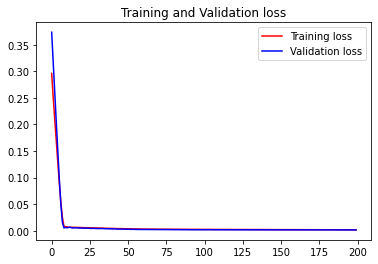

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((203, 1), (130, 1))

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation

In [ ]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2178.798877511378
Train data MSE:  4747164.548644841
Train data MAE:  1692.23174839101
-------------------------------------------------------------------------------------
Test data RMSE:  2047.1673246118576
Test data MSE:  4190894.05495847
Test data MAE:  1588.4578425365385


In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9687501931679257
Test data explained variance regression score: 0.9556284808204744


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9684407275580148
Test data R2 score: 0.9556071917848932


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.002701918277443198
Test data MGD:  0.0018070033381159115
----------------------------------------------------------------------
Train data MPD:  109.75541000570068
Test data MPD:  85.55661635612476


In [ ]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'BTC price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing BTC price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='BTC')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()